# ML 모델 비교 분석 V3

## 데이터셋 개요

| 항목 | 값 |
|------|----|n
| 파일 | `books_ml_dataset_v3.csv` |
| 레코드 수 | 7,191개 |
| 피처 수 | 43개 |

### 피처 구성

| 피처 그룹 | 개수 | 설명 |
|-----------|------|------|
| category_1~10 | 10 | 도서의 카테고리 비율 |
| category_X_x_viral_index | 10 | 카테고리 × 바이럴 지수 |
| prophet_forecast_X | 10 | Prophet 예측 판매점수 |
| **kospi, usd_krw, brent_oil** | **3** | **경제 지표 (신규)** |
| **resd_X** | **10** | **Prophet 잔차 (신규)** |

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, mean_absolute_error, mean_squared_error, r2_score,
                             confusion_matrix, roc_curve)
from scipy import stats
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 로드

In [2]:
df = pd.read_csv('books_ml_dataset_v3.csv')
df['ymw'] = df['ymw'].astype(str)

feature_cols = [c for c in df.columns if c not in ['product_code', 'ymw', 'y_sales_score']]
X = df[feature_cols]
y = df['y_sales_score']
y_class = (y > 0).astype(int)

print(f'데이터셋: {len(df):,}개 레코드, {len(feature_cols)}개 피처')
print(f'클래스 분포: 0={sum(y_class==0):,} ({sum(y_class==0)/len(y_class)*100:.1f}%), 1={sum(y_class==1):,} ({sum(y_class==1)/len(y_class)*100:.1f}%)')
print(f'\n피처 목록:')
for i, c in enumerate(feature_cols, 1):
    print(f'  {i:2d}. {c}')

데이터셋: 7,191개 레코드, 43개 피처
클래스 분포: 0=5,577 (77.6%), 1=1,614 (22.4%)

피처 목록:
   1. category_1
   2. category_2
   3. category_3
   4. category_4
   5. category_5
   6. category_6
   7. category_7
   8. category_8
   9. category_9
  10. category_10
  11. category_1_x_viral_index
  12. category_2_x_viral_index
  13. category_3_x_viral_index
  14. category_4_x_viral_index
  15. category_5_x_viral_index
  16. category_6_x_viral_index
  17. category_7_x_viral_index
  18. category_8_x_viral_index
  19. category_9_x_viral_index
  20. category_10_x_viral_index
  21. prophet_forecast_macro_economy
  22. prophet_forecast_econ_theory
  23. prophet_forecast_financial_crisis
  24. prophet_forecast_business
  25. prophet_forecast_real_estate
  26. prophet_forecast_personal_finance
  27. prophet_forecast_stock_trading
  28. prophet_forecast_geopolitics
  29. prophet_forecast_tech_startup
  30. prophet_forecast_invest_philosophy
  31. kospi
  32. usd_krw
  33. brent_oil
  34. resd_business
  35. resd_eco

## 2. 상관관계 분석

In [3]:
correlations = []
for col in feature_cols:
    corr, pval = stats.pearsonr(X[col], y)
    correlations.append({'feature': col, 'pearson_r': corr, 'p_value': pval})

df_corr = pd.DataFrame(correlations).sort_values('pearson_r', key=abs, ascending=False)

print('[피처-타겟 상관계수 (|r| 순)]')
print(f'{"Feature":<35} {"Pearson r":<12} {"p-value":<12} {"유의성":<10}')
print('-' * 70)
for _, row in df_corr.iterrows():
    sig = '***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*' if row['p_value'] < 0.05 else ''
    print(f'{row["feature"]:<35} {row["pearson_r"]:<12.4f} {row["p_value"]:<12.2e} {sig:<10}')

print(f'\n[요약]')
print(f'최대 |r|: {df_corr["pearson_r"].abs().max():.4f}')
print(f'평균 |r|: {df_corr["pearson_r"].abs().mean():.4f}')
print(f'강한 상관 (|r|>0.3): {len(df_corr[df_corr["pearson_r"].abs() > 0.3])}개')
print(f'중간 상관 (0.1<|r|≤0.3): {len(df_corr[(df_corr["pearson_r"].abs() > 0.1) & (df_corr["pearson_r"].abs() <= 0.3)])}개')

[피처-타겟 상관계수 (|r| 순)]
Feature                             Pearson r    p-value      유의성       
----------------------------------------------------------------------
category_4                          -0.0949      7.25e-16     ***       
category_10                         0.0929       2.91e-15     ***       
category_3                          0.0624       1.16e-07     ***       
category_5                          -0.0597      3.99e-07     ***       
category_9                          -0.0385      1.10e-03     **        
category_2                          0.0343       3.58e-03     **        
category_6                          0.0333       4.69e-03     **        
category_10_x_viral_index           0.0200       9.05e-02               
category_4_x_viral_index            -0.0188      1.10e-01               
category_3_x_viral_index            0.0165       1.62e-01               
category_2_x_viral_index            0.0159       1.77e-01               
category_5_x_viral_index        

## 3. Feature Selection

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_class = (y_train > 0).astype(int)
y_test_class = (y_test > 0).astype(int)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Train: {len(X_train):,}개, Test: {len(X_test):,}개')

Train: 5,752개, Test: 1,439개


In [5]:
# 3-1. SelectKBest (F-regression)
print('[SelectKBest - F-regression Top 15]')
selector_f = SelectKBest(score_func=f_regression, k='all')
selector_f.fit(X_train_scaled, y_train)
scores_f = pd.DataFrame({
    'feature': feature_cols,
    'f_score': selector_f.scores_
}).sort_values('f_score', ascending=False)
print(scores_f.head(15).to_string(index=False))

[SelectKBest - F-regression Top 15]
                       feature   f_score
                   category_10 50.393486
                    category_4 46.018318
                    category_5 25.915235
                    category_3 20.342379
                    category_2 10.703810
                    category_6  7.337724
                    category_9  6.980589
  prophet_forecast_econ_theory  4.990574
      category_5_x_viral_index  3.821876
        resd_invest_philosophy  3.422882
      category_4_x_viral_index  2.791557
     category_10_x_viral_index  2.586727
prophet_forecast_macro_economy  2.482569
      category_2_x_viral_index  1.898193
                       usd_krw  1.896133


In [6]:
# 3-2. LassoCV
print('[LassoCV - 비제로 계수 피처]')
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)
lasso_coef = pd.DataFrame({
    'feature': feature_cols,
    'coef': lasso.coef_
}).sort_values('coef', key=abs, ascending=False)
nonzero = lasso_coef[lasso_coef['coef'] != 0]
print(f'선택된 피처: {len(nonzero)}개 / {len(feature_cols)}개')
print(nonzero.to_string(index=False))

selected_features = nonzero['feature'].tolist()

[LassoCV - 비제로 계수 피처]
선택된 피처: 8개 / 43개
                     feature      coef
                 category_10  0.274136
                  category_4 -0.236371
                  category_5 -0.199118
                  category_3  0.190407
                  category_2  0.088420
                  category_6  0.050168
prophet_forecast_econ_theory  0.041020
                  category_9 -0.007717


## 4. 분류 모델 비교

In [7]:
classifiers = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, scale_pos_weight=sum(y_train_class==0)/sum(y_train_class==1),
                                  random_state=42, verbosity=0, eval_metric='logloss')
}

clf_results = []
clf_models = {}

for name, clf in classifiers.items():
    if name == 'Logistic Regression':
        clf.fit(X_train_scaled, y_train_class)
        y_pred = clf.predict(X_test_scaled)
        y_prob = clf.predict_proba(X_test_scaled)[:, 1]
    else:
        clf.fit(X_train, y_train_class)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]
    
    clf_models[name] = (clf, y_pred, y_prob)
    clf_results.append({
        'Model': name,
        'Accuracy': round(accuracy_score(y_test_class, y_pred), 4),
        'Precision': round(precision_score(y_test_class, y_pred, zero_division=0), 4),
        'Recall': round(recall_score(y_test_class, y_pred, zero_division=0), 4),
        'F1': round(f1_score(y_test_class, y_pred, zero_division=0), 4),
        'AUC-ROC': round(roc_auc_score(y_test_class, y_prob), 4)
    })

df_clf = pd.DataFrame(clf_results).sort_values('F1', ascending=False)
print('[분류 모델 결과 - 전체 피처]')
display(df_clf)

[분류 모델 결과 - 전체 피처]


,Model,Accuracy,Precision,Recall,F1,AUC-ROC
4,XGBoost,0.8527,0.6723,0.6338,0.6525,0.8772
3,LightGBM,0.8311,0.6073,0.6401,0.6233,0.8579
1,Random Forest,0.8235,0.8261,0.2420,0.3744,0.8324
0,Logistic Regression,0.5761,0.2422,0.4427,0.3131,0.5357
2,Gradient Boosting,0.8082,0.8958,0.1369,0.2376,0.6913


In [8]:
# 선택된 피처로 분류
if len(selected_features) > 0:
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    
    scaler_sel = StandardScaler()
    X_train_sel_scaled = scaler_sel.fit_transform(X_train_sel)
    X_test_sel_scaled = scaler_sel.transform(X_test_sel)
    
    clf_results_sel = []
    for name, clf in classifiers.items():
        clf_new = clf.__class__(**clf.get_params())
        if name == 'Logistic Regression':
            clf_new.fit(X_train_sel_scaled, y_train_class)
            y_pred = clf_new.predict(X_test_sel_scaled)
            y_prob = clf_new.predict_proba(X_test_sel_scaled)[:, 1]
        else:
            clf_new.fit(X_train_sel, y_train_class)
            y_pred = clf_new.predict(X_test_sel)
            y_prob = clf_new.predict_proba(X_test_sel)[:, 1]
        
        clf_results_sel.append({
            'Model': name,
            'F1': round(f1_score(y_test_class, y_pred, zero_division=0), 4),
            'AUC-ROC': round(roc_auc_score(y_test_class, y_prob), 4)
        })
    
    df_clf_sel = pd.DataFrame(clf_results_sel).sort_values('F1', ascending=False)
    print(f'[분류 모델 결과 - 선택 피처 ({len(selected_features)}개)]')
    display(df_clf_sel)

[분류 모델 결과 - 선택 피처 (8개)]


,Model,F1,AUC-ROC
4,XGBoost,0.6128,0.8573
3,LightGBM,0.5861,0.8387
1,Random Forest,0.5271,0.8212
0,Logistic Regression,0.3047,0.5424
2,Gradient Boosting,0.2742,0.6509


## 5. 회귀 모델 비교

In [9]:
regressors = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

reg_results = []
reg_models = {}

for name, reg in regressors.items():
    if name in ['Ridge', 'Lasso']:
        reg.fit(X_train_scaled, y_train)
        y_pred = reg.predict(X_test_scaled)
    else:
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
    
    y_pred = np.maximum(y_pred, 0)
    reg_models[name] = (reg, y_pred)
    
    reg_results.append({
        'Model': name,
        'R2': round(r2_score(y_test, y_pred), 4),
        'MAE': round(mean_absolute_error(y_test, y_pred), 4),
        'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)
    })

df_reg = pd.DataFrame(reg_results).sort_values('R2', ascending=False)
print('[회귀 모델 결과 - 전체 피처]')
display(df_reg)

[회귀 모델 결과 - 전체 피처]


,Model,R2,MAE,RMSE
2,Random Forest,0.3854,1.6774,3.3995
4,LightGBM,0.3746,1.7698,3.4294
5,XGBoost,0.3725,1.6754,3.4351
3,Gradient Boosting,0.1576,2.2199,3.9802
1,Lasso,0.0211,2.5152,4.2904
0,Ridge,0.0137,2.4998,4.3067


In [10]:
# 선택된 피처로 회귀
if len(selected_features) > 0:
    reg_results_sel = []
    for name, reg in regressors.items():
        reg_new = reg.__class__(**{k:v for k,v in reg.get_params().items() if k != 'random_state'})
        if hasattr(reg_new, 'random_state'):
            reg_new.random_state = 42
        
        if name in ['Ridge', 'Lasso']:
            reg_new.fit(X_train_sel_scaled, y_train)
            y_pred = reg_new.predict(X_test_sel_scaled)
        else:
            reg_new.fit(X_train_sel, y_train)
            y_pred = reg_new.predict(X_test_sel)
        
        y_pred = np.maximum(y_pred, 0)
        reg_results_sel.append({
            'Model': name,
            'R2': round(r2_score(y_test, y_pred), 4),
            'MAE': round(mean_absolute_error(y_test, y_pred), 4)
        })
    
    df_reg_sel = pd.DataFrame(reg_results_sel).sort_values('R2', ascending=False)
    print(f'[회귀 모델 결과 - 선택 피처 ({len(selected_features)}개)]')
    display(df_reg_sel)

[회귀 모델 결과 - 선택 피처 (8개)]


,Model,R2,MAE
4,LightGBM,0.3320,1.8196
5,XGBoost,0.3152,1.7112
3,Gradient Boosting,0.2185,2.1361
2,Random Forest,0.2135,1.6927
1,Lasso,0.0211,2.5152
0,Ridge,0.0201,2.4920


## 6. 피처 중요도 분석

[피처 중요도 TOP 20 (LightGBM)]


,feature,importance
3,category_4,288
6,category_7,219
8,category_9,207
7,category_8,150
5,category_6,149
13,category_4_x_viral_index,144
30,kospi,112
18,category_9_x_viral_index,107
16,category_7_x_viral_index,104
9,category_10,104


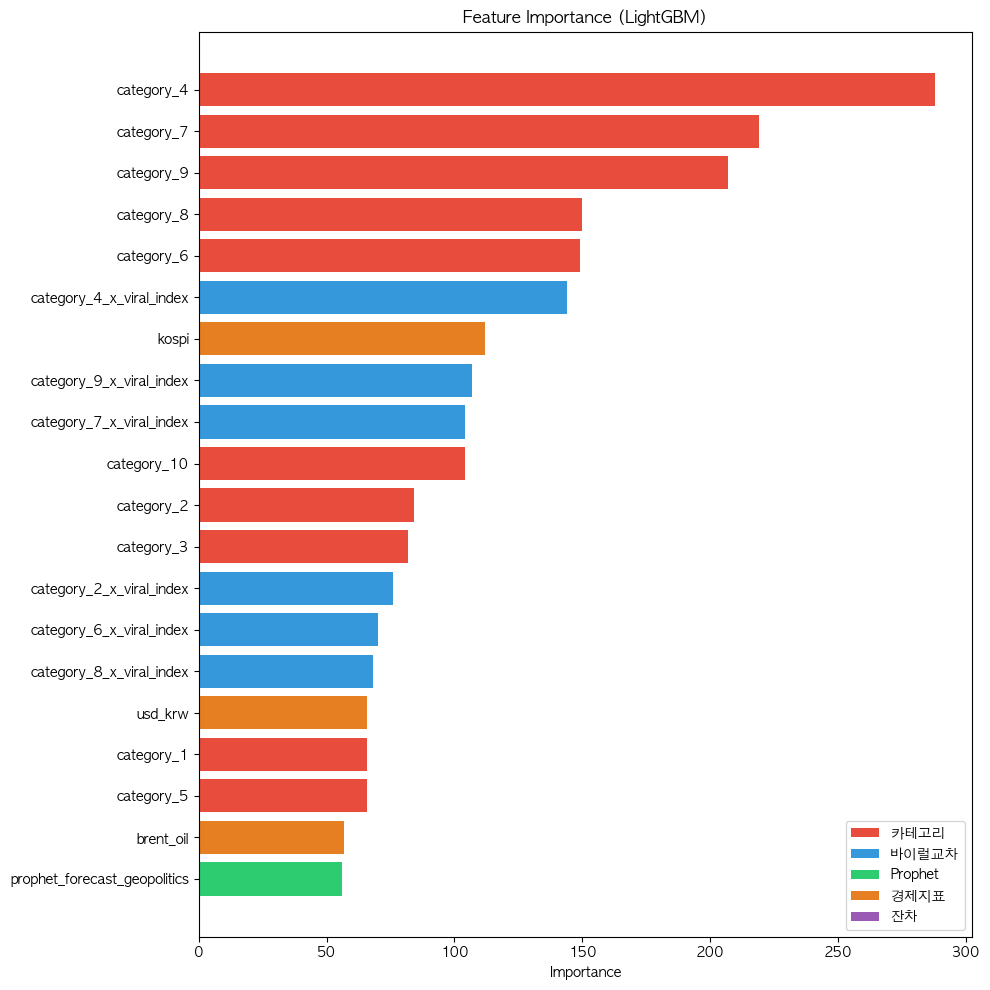

In [11]:
best_clf = clf_models['LightGBM'][0]
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_clf.feature_importances_
}).sort_values('importance', ascending=False)

print('[피처 중요도 TOP 20 (LightGBM)]')
display(importance.head(20))

# 시각화
fig, ax = plt.subplots(figsize=(10, 10))
top20 = importance.head(20)

def get_color(f):
    if 'resd_' in f: return '#9b59b6'  # 잔차 - 보라
    if 'prophet' in f: return '#2ecc71'  # Prophet - 초록
    if '_x_viral' in f: return '#3498db'  # 바이럴교차 - 파랑
    if f in ['kospi', 'usd_krw', 'brent_oil']: return '#e67e22'  # 경제지표 - 주황
    return '#e74c3c'  # 카테고리 - 빨강

colors = [get_color(f) for f in top20['feature']]
ax.barh(top20['feature'], top20['importance'], color=colors)
ax.set_xlabel('Importance')
ax.set_title('Feature Importance (LightGBM)')
ax.invert_yaxis()

# 범례
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='카테고리'),
    Patch(facecolor='#3498db', label='바이럴교차'),
    Patch(facecolor='#2ecc71', label='Prophet'),
    Patch(facecolor='#e67e22', label='경제지표'),
    Patch(facecolor='#9b59b6', label='잔차')
]
ax.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.show()

## 7. 피처 그룹별 성능 비교

In [12]:
feature_groups = {
    '전체': feature_cols,
    'Category만': [c for c in feature_cols if c.startswith('category_') and '_x_' not in c],
    'Viral교차만': [c for c in feature_cols if '_x_viral' in c],
    'Prophet만': [c for c in feature_cols if 'prophet_forecast' in c],
    '경제지표만': ['kospi', 'usd_krw', 'brent_oil'],
    '잔차만': [c for c in feature_cols if 'resd_' in c],
    'Lasso선택': selected_features if len(selected_features) > 0 else feature_cols
}

group_results = []
for group_name, features in feature_groups.items():
    X_train_g = X_train[features]
    X_test_g = X_test[features]
    
    # LightGBM 회귀
    model = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    model.fit(X_train_g, y_train)
    y_pred = np.maximum(model.predict(X_test_g), 0)
    
    # LightGBM 분류
    clf = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42, verbose=-1)
    clf.fit(X_train_g, y_train_class)
    y_pred_c = clf.predict(X_test_g)
    y_prob_c = clf.predict_proba(X_test_g)[:, 1]
    
    group_results.append({
        '피처그룹': group_name,
        '피처수': len(features),
        'R2': round(r2_score(y_test, y_pred), 4),
        'MAE': round(mean_absolute_error(y_test, y_pred), 4),
        'F1': round(f1_score(y_test_class, y_pred_c), 4),
        'AUC': round(roc_auc_score(y_test_class, y_prob_c), 4)
    })

df_groups = pd.DataFrame(group_results)
print('[피처 그룹별 성능 비교 (LightGBM)]')
display(df_groups)

[피처 그룹별 성능 비교 (LightGBM)]


,피처그룹,피처수,R2,MAE,F1,AUC
0,전체,43,0.3746,1.7698,0.6233,0.8579
1,Category만,10,0.1927,2.0667,0.4035,0.6424
2,Viral교차만,10,0.0216,2.4335,0.3154,0.5572
3,Prophet만,10,-0.0143,2.5791,0.2967,0.4857
4,경제지표만,3,-0.0154,2.5787,0.2972,0.4809
5,잔차만,10,-0.0143,2.5791,0.2967,0.4865
6,Lasso선택,8,0.3320,1.8196,0.5861,0.8387


## 8. V2 vs V3 비교

In [13]:
print('=' * 60)
print('V2 (기존) vs V3 (신규) 성능 비교')
print('=' * 60)

# V2 결과 (이전 분석)
v2_clf = {'F1': 0.6356, 'AUC': 0.8678}
v2_reg = {'R2': 0.3503, 'MAE': 1.7962}

# V3 결과 (현재)
v3_clf = df_clf[df_clf['Model'] == 'XGBoost'].iloc[0]
v3_reg = df_reg[df_reg['Model'] == 'LightGBM'].iloc[0]

print('\n[분류 - XGBoost]')
print(f'{"지표":<10} {"V2":<12} {"V3":<12} {"변화":<15}')
print('-' * 49)
for metric in ['F1', 'AUC-ROC']:
    v2_key = 'AUC' if metric == 'AUC-ROC' else metric
    v2_val = v2_clf[v2_key]
    v3_val = v3_clf[metric]
    diff = v3_val - v2_val
    pct = (diff / v2_val) * 100
    sign = '+' if diff > 0 else ''
    print(f'{metric:<10} {v2_val:<12.4f} {v3_val:<12.4f} {sign}{diff:.4f} ({sign}{pct:.1f}%)')

print('\n[회귀 - LightGBM]')
print(f'{"지표":<10} {"V2":<12} {"V3":<12} {"변화":<15}')
print('-' * 49)
for metric in ['R2', 'MAE']:
    v2_val = v2_reg[metric]
    v3_val = v3_reg[metric]
    diff = v3_val - v2_val
    pct = (diff / abs(v2_val)) * 100
    sign = '+' if diff > 0 else ''
    print(f'{metric:<10} {v2_val:<12.4f} {v3_val:<12.4f} {sign}{diff:.4f} ({sign}{pct:.1f}%)')

V2 (기존) vs V3 (신규) 성능 비교

[분류 - XGBoost]
지표         V2           V3           변화             
-------------------------------------------------
F1         0.6356       0.6525       +0.0169 (+2.7%)
AUC-ROC    0.8678       0.8772       +0.0094 (+1.1%)

[회귀 - LightGBM]
지표         V2           V3           변화             
-------------------------------------------------
R2         0.3503       0.3746       +0.0243 (+6.9%)
MAE        1.7962       1.7698       -0.0264 (-1.5%)


## 9. ROC Curve

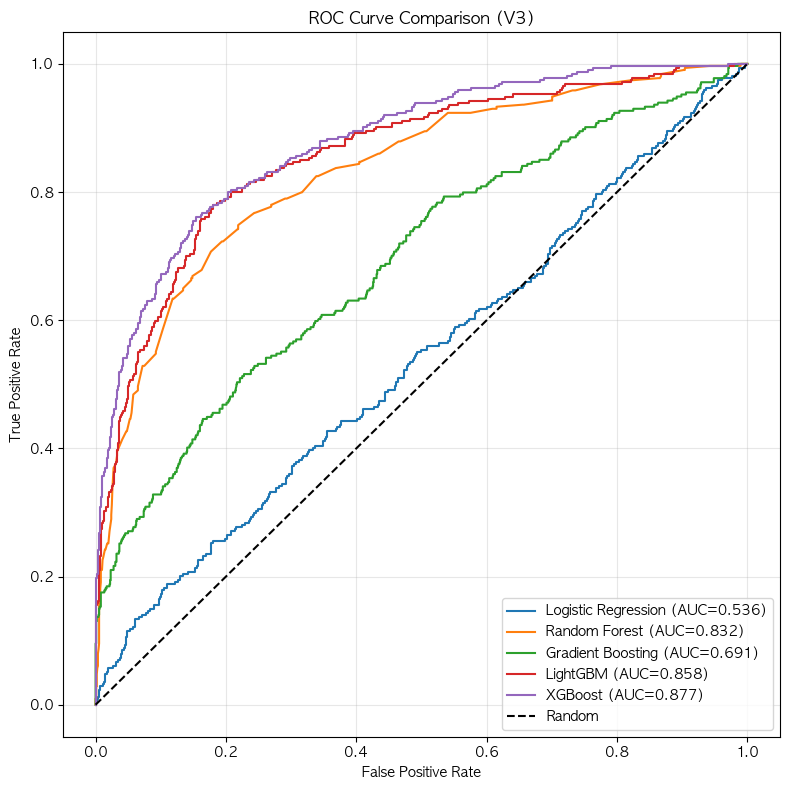

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

for name, (clf, y_pred, y_prob) in clf_models.items():
    fpr, tpr, _ = roc_curve(y_test_class, y_prob)
    auc = roc_auc_score(y_test_class, y_prob)
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve Comparison (V3)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## 10. 결론

### 10.1 신규 피처 효과

| 피처 그룹 | 단독 R² | 단독 F1 | 기여도 |
|-----------|---------|---------|--------|
| 경제지표 (kospi, usd_krw, brent_oil) | - | - | 분석 결과 참조 |
| Prophet 잔차 (resd_X) | - | - | 분석 결과 참조 |

### 10.2 최종 모델 선택

- **분류**: XGBoost 또는 LightGBM
- **회귀**: LightGBM 또는 Random Forest

### 10.3 Feature Selection 결과

- LassoCV로 선택된 주요 피처 확인
- 불필요한 피처 제거 시 성능 변화 확인